Данная работа посвящена изучению кодов Хэмминга в (R, $\delta$)-плоскости, а также жёстким и мягким решениям при их декодировании.

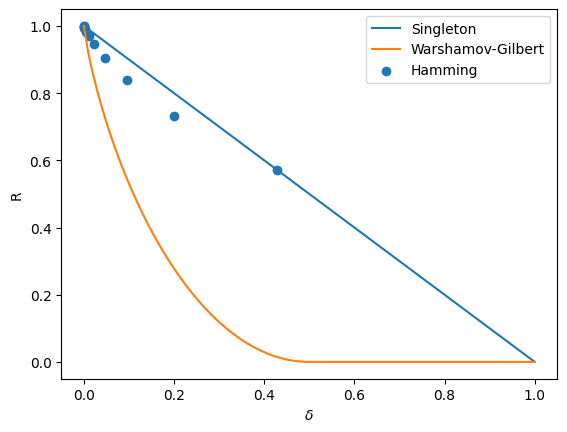

In [ ]:
import matplotlib.pyplot as plt
from math import log2
import numpy as np

def Singleton_bound(d : int):
    return 1 - d

def h(p : float):
    if (p == 0) or (p == 1):
        return 0
    return -p*log2(p) - (1 - p)*log2(1 - p)

def GilbertWarshamov_bound(d : int):
    if d > 0.5:
        return 0
    return 1 - h(d)

def xarg(func, args):
    return [func(arg) for arg in args]

def getHamming(m : int):
    n = 2**m - 1
    k = n - m
    d = 3
    return k/n, d/n

d = np.linspace(0, 1, 100)
sb = xarg(Singleton_bound, d)
gwb = xarg(GilbertWarshamov_bound, d)
hR = []
hd = []
for m in range(3, 15):
    _r, _d = getHamming(m)
    hR += [_r]
    hd += [_d]

plt.plot(d, sb, label="Singleton")
plt.plot(d, gwb, label="Warshamov-Gilbert")
plt.scatter(hd, hR, label="Hamming")
plt.xlabel("$\\delta$")
plt.ylabel("R")
plt.legend()
plt.show()

In [195]:
class Hamming74:
    def __init__(self):
        self.G = np.array([
            [1,0,0,0,1,1,0],
            [0,1,0,0,1,0,1],
            [0,0,1,0,0,1,1],
            [0,0,0,1,1,1,1]
        ], dtype=int)
        
        self.H = np.array([
            [1,1,0,1,1,0,0],
            [1,0,1,1,0,1,0],
            [0,1,1,1,0,0,1]
        ], dtype=int)
    
    def encode(self, data_bits):
        return np.dot(data_bits, self.G) % 2
    
    def decode_hard(self, received_bits):
        syndrome = np.dot(received_bits, self.H.T) % 2
        # синдром - позиция ошибки в двоичном коде
        if np.any(syndrome):
            error_pos = int(''.join(map(str, syndrome)), 2) - 1
            received_bits[error_pos] ^= 1
        return received_bits[:4]

    # LLR - log likelyhood ratio
    def decode_soft(self, llrs: np.ndarray):
            best_metric = -float("inf")
            best_data = np.array([])
            for i in range(16):
                data_bits = np.array([(i >> j) & 1 for j in range(3, -1, -1)])
                codeword = self.encode(data_bits)
                bpsk = 1 - 2 * codeword # BPSK
                metric = np.sum(llrs * bpsk) # корреляция
                if metric > best_metric:
                    best_metric = metric
                    best_data = data_bits
            return best_data.tolist()

# input: BPSK(-1, +1)
def AWGN_channel(signal, snr_dB):
    P_signal = 1.0
    P_noise = P_signal / 10**(snr_dB / 10)
    noise_real = np.random.normal(0, np.sqrt(P_noise), size=signal.shape)
    received = signal + noise_real
    return received

input_bits_count = 4000 # делится на 4
data_bits = np.random.randint(0, 2, input_bits_count).tolist()
hamming = Hamming74()

def transmit(data : list[int], snr_dB : float, soft : bool):
    result = []
    for block_start in range(0, len(data), 4):
        data_block = np.array(data[block_start:block_start + 4])
        codeword = hamming.encode(data_block)
        bpsk_symbols = 1 - 2*codeword
        noisy_symbols = AWGN_channel(bpsk_symbols, snr_dB)
        if soft:
            llrs = 2 * noisy_symbols * (10 ** (snr_dB / 10.0)) # 2Y/noise^2
            decoded = hamming.decode_soft(llrs)
        else:
            restored = [1 if val else 0 for val in (noisy_symbols < 0)]
            decoded = hamming.decode_hard(restored)
        result.extend(decoded)
    return result

def check(data_in : list[int], data_out : list[int]):
    errors = 0
    for i, o in zip(data_in, data_out):
        errors += (i != o)
    return errors

print("input len:", len(data_bits))

print("SNR = -1")
hard_result = transmit(data_bits, -1, False)
print("hard errors:", check(data_bits, hard_result))
soft_result = transmit(data_bits, -1, True)
print("soft errors:", check(data_bits, soft_result))

print("SNR = 1.5")
hard_result = transmit(data_bits, 1.5, False)
print("hard errors:", check(data_bits, hard_result))
soft_result = transmit(data_bits, 1.5, True)
print("soft errors:", check(data_bits, soft_result))

input len: 4000
SNR = -1
hard errors: 943
soft errors: 537
SNR = 1.5
hard errors: 595
soft errors: 217


Вывод: мягкие решения существенно уменьшают количество ошибок. Также видно, что при одинаковой вероятности ошибки $10\cdot\lg \frac{P_{hard}}{P_{soft}} = SNR_{hard} - SNR_{soft} \approx 2.5$. То есть мы получили выигрыш в 2.5 дБ.